In [1]:
from scipy.io import netcdf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import xarray
import pandas as pd
import datetime
from datetime import datetime, timedelta
import geopandas as gpd
from itertools import groupby

Matplotlib is building the font cache; this may take a moment.


In [2]:
#Check memory: ps aux  | awk '{print $6/1024 " MB\t\t" $11}'  | sort -nr | head -1

In [3]:
wind_facilities = pd.read_csv('wind-facilities.csv')
data = xarray.open_dataset('/g/data/v46/lh2344/LLJ_2015_18.nc')
jetnight = xarray.open_dataset('/g/data/v46/lh2344/jetnightsv2')

windlat = wind_facilities.Latitude
windlong = wind_facilities.Longitude

In [4]:
def contourplot(profile, title):
    levels = np.arange(0,profile.max(),1)
    src = ccrs.PlateCarree()
    ax = plt.axes(projection=src)
    
    cmap=matplotlib.cm.get_cmap('RdPu')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    lh = ax.gridlines(xlocs=range(131,171,1), ylocs=range(-39,-27,1),draw_labels=True)
    lh.top_labels = False
    lh.right_labels = False
    ch = ax.contourf(lon2d, lat2d, profile, levels, extend = 'both',cmap=cmap)
    ax.coastlines('50m', linewidth=1)
    ax.scatter(windlong, windlat, marker='x', color='blue', label = 'windfarms')
    ax.set_title(title)
    ax.set_ylim(lat2d.min(), lat2d.max())
    ax.set_xlim(lon2d.min(),lon2d.max())
    ax.legend(loc = [0,1])
    out=plt.colorbar(ch,cax=cax, **kw)
    out.set_label('Frequency',size=10)

In [5]:
def gridpoints(latitude, longitude):
    lat = np.linspace(lat2d.min(), lat2d.max(), nj) #min, max lat
    lon = np.linspace(lon2d.min(),lon2d.max(),ni) #min, max lon
    abs_val_lat, abs_val_lon = np.abs(lat - latitude), np.abs(lon - longitude)
    lat_grid, lon_grid  =  abs_val_lat.argmin(), abs_val_lon.argmin()
    return lat_grid, lon_grid
    #print('lat,lon', lat_grid,',', lon_grid)

In [6]:
dstart = datetime(2015,1,1,0,0,0)
ndays = (365*3)+366
nj = 40
ni = 83
nt = ndays*24

jstart = 241
jend = jstart + nj
istart = 690
iend = istart + ni
pstart = 28
pend = 37
plevels = pend-pstart
heights_std = np.arange(100.0,1200.0,100.0)

In [7]:
# jetnight2 = jetnight.jetnight2_v2
# ws100m_jn = jetnight.ws100m_jnv2
# ws100m_nonjn = jetnight.ws100m_nonjnv2
# jetnight_sum = jetnight2.sum(axis=0)
wsprof_interp = data.wsprof_interp

lon2d = data.lon2d
lat2d = data.lat2d
topog = xarray.open_dataset('Downloads/topog-an-slv-PT0H-BARRA_R-v1-20150207T0000Z.nc')
topog = topog.topog
topog = topog[jstart:jend,istart:iend]

profmax_ind = data.profmax_ind
profmax = data.profmax
wsabove = data.wsabove
wsbelow = data.wsbelow

coords_isosurf={
    wsprof_interp.dims[0]:wsprof_interp.coords[wsprof_interp.dims[0]],
    wsprof_interp.dims[2]:wsprof_interp.coords[wsprof_interp.dims[2]],   # latitude name and dimension
    wsprof_interp.dims[3]:wsprof_interp.coords[wsprof_interp.dims[3]]    # longitude name and dimension
}

In [8]:
solartime = timedelta(hours=(144.96*12/180))
EST = timedelta(hours = 10)
t = np.arange(dstart + solartime, dstart + timedelta(hours=nt)+solartime, timedelta(hours=1)).astype(datetime)
t_EST = np.arange(dstart + EST, dstart + timedelta(hours=nt)+EST, timedelta(hours=1)).astype(datetime)

In [9]:
# variable criteria algorithm

fixed_criteria = 2
variable_criteria = 0.2 # windspeed above and below is more than x% below the maxima
percent =  1 - variable_criteria 

speed_crit = profmax > 7
#falloff_crit = (profmax - min(wsprof_interp.isel(isosurf = (profmax_ind,10)))) > 5
below_crit = wsbelow <= percent * profmax
above_crit = wsabove <= 0.9 * profmax

jetbinary_variable = (speed_crit & below_crit & above_crit) * 1

# fixed criteria algorithm
jetbinary_fixed = ((profmax - wsabove >= fixed_criteria) & (profmax - wsbelow >= fixed_criteria)) * 1

wsprof_interp['time'] = t_EST
jetbinary_variable['time'] = t_EST
profmax['time']=t_EST

totaljets_variable = jetbinary_variable.sum(dim = 'time')
maxwind_jet = profmax.where(jetbinary_variable)

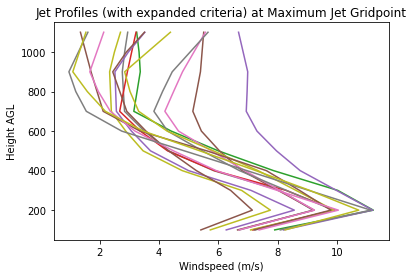

In [10]:
profiles = wsprof_interp.where(jetbinary_variable==1, drop = True)

for t in range(400,600):
    plt.plot(profiles[t,:,19,22], heights_std)
    plt.title('Jet Profiles (with expanded criteria) at Maximum Jet Gridpoint')
    plt.xlabel('Windspeed (m/s)')
    plt.ylabel('Height AGL')
plt.savefig('Jet_profiles_expanded_crit')

/local/v46/lh2344/tmp/ipykernel_29646/3419853878.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=24)


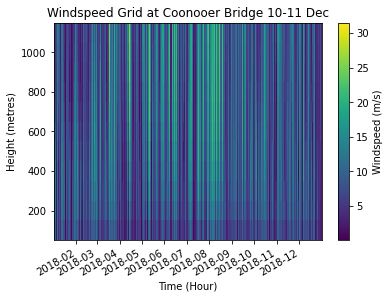

In [10]:
start = datetime(2018,1,1,12,0,0)
end = datetime(2018,12,31,12,0,0)
time_slice = slice(start, end)
wsprof_slice = wsprof_interp[...,19,22].sel(time = time_slice)

wsprof_slice.plot(x='time', cbar_kwargs = {'label': 'Windspeed (m/s)'})
plt.title('Windspeed Grid at Coonooer Bridge 10-11 Dec')
plt.ylabel('Height (metres)')
plt.xlabel('Time (Hour)')
#plt.xticks(wsprof_slice.time, pd.date_range(start, end, freq = 'H').hour, rotation = 0)
plt.locator_params(axis='x', nbins=24)
plt.savefig('Windspeed Grid 10-11 Dec')

In [11]:
wsprof_interp[...,19,22].sel(time = datetime(2018,12,11,3,0,0))


<xarray.DataArray 'wsprof_interp' (isosurf: 11)>
array([ 8.751929, 11.431697,  9.910836,  8.389974,  7.103714,  5.839651,
        5.390159,  5.411792,  5.352241,  5.097332,  4.842422])
Coordinates:
    time       datetime64[ns] 2018-12-11T03:00:00
  * isosurf    (isosurf) float64 100.0 200.0 300.0 400.0 ... 900.0 1e+03 1.1e+03
    latitude   int64 19
    longitude  int64 22

In [19]:
gridpoints = 2
jet = jetbinary_variable.sel(time = slice(datetime(2018,12,10,18,0,0), datetime(2018,12,11,12,0,0)), latitude = slice(19-gridpoints,19+gridpoints), longitude = slice(22-gridpoints,22+gridpoints))
jet.sum(dim = ['latitude', 'longitude'])

<xarray.DataArray (time: 19)>
array([0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 3, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * time     (time) datetime64[ns] 2018-12-10T18:00:00 ... 2018-12-11T12:00:00

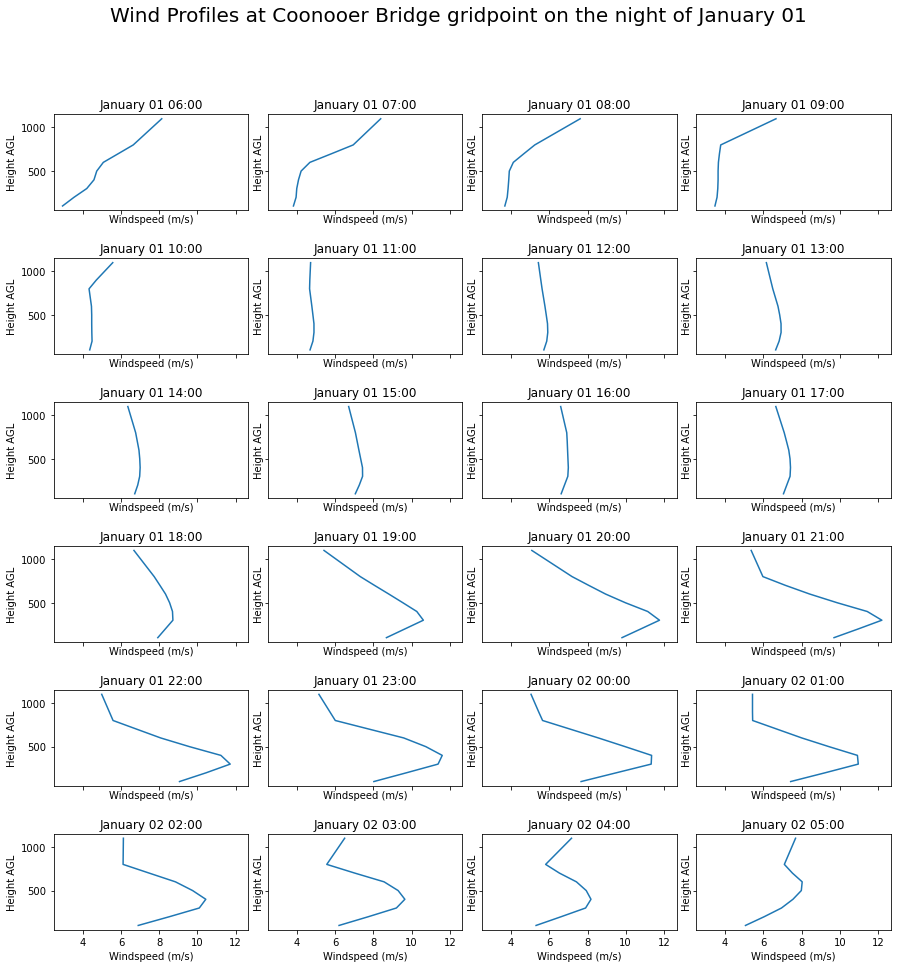

In [14]:
n_rows = 6
n_columns = 4
fig, ax = plt.subplots(n_rows, n_columns, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5, wspace=0.1)
ax = ax.reshape((-1, n_columns))

start_date = datetime(2018,1,1,6,0,0)
end_date = datetime(2018,1,2,6,0,0)

for i, t in enumerate(np.arange(start_date, end_date, timedelta(hours=1)).astype(datetime)):
    r = int(i/n_columns)
    c = i%n_columns
    
    
    ax[r,c].plot(wsprof_interp[...,19,22].sel(time = t), heights_std)
    ax[r,c].set_title(t.strftime("%B %d %H:%M"))
    ax[r,c].set_xlabel('Windspeed (m/s)')
    ax[r,c].set_ylabel('Height AGL')
    #plt.show()

plt.suptitle('Wind Profiles at Coonooer Bridge gridpoint on the night of '+ start_date.strftime("%B %d"), fontsize = 20)
plt.savefig('Conooer Bridge profiles')

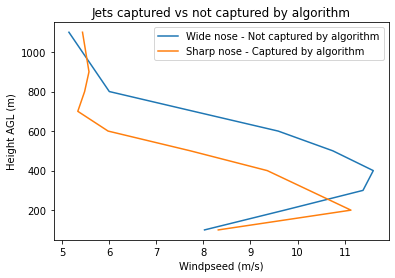

In [23]:
plt.plot(wsprof_interp[...,19,22].sel(time = datetime(2018,1,1,23,0)), heights_std, label = 'Wide nose - Not captured by algorithm')
plt.title('January 1 23:00')
plt.xlabel('Windpseed (m/s)')
plt.ylabel('Height AGL (m)')

plt.plot(wsprof_interp[...,19,22].sel(time = datetime(2018,12,11,2,0)), heights_std, label = 'Sharp nose - Captured by algorithm')
plt.title('Jets captured vs not captured by algorithm')
plt.xlabel('Windpseed (m/s)')
plt.ylabel('Height AGL (m)')
plt.savefig('Large nose example')
plt.legend()

In [ ]:
# 6am (including) to 5pm
daytime = jetbinary_variable[(jetbinary_variable.time.dt.hour>=6)&(jetbinary_variable.time.dt.hour<18)]

# NOT daytime, therefore 6pm (including) to 5am
nighttime = jetbinary_variable[~((jetbinary_variable.time.dt.hour>=6)&(jetbinary_variable.time.dt.hour<18))]

totaljets_night = nighttime.sum(dim='time')
print('Total jets during daytime', daytime.sum())
print('Total jets during nighttime', nighttime.sum())
print((nighttime.sum()/(daytime.sum()+nighttime.sum()))*100, '% of jets occur at night')

In [ ]:
# How many nights contain at least one jet?
nighttime1 = nighttime*1
jethours_sum = nighttime1.sum(dim = ['latitude', 'longitude'])
nonzerohour_sum = np.count_nonzero(jethours_sum)
print('Proportion of hours with at least one jet occurence:', np.round((nonzerohour_sum/len(nighttime1))*100,4), '%')

In [ ]:
ws100m = wsprof_interp[:,0,...]
ws100m_night = ws100m[~((ws100m.time.dt.hour>=6)&(ws100m.time.dt.hour<18))]

nighttime1_n = nighttime1.to_numpy()
# nighttime1 = xarray.DataArray(nighttime1_reshaped, dims=("day","hour", "latitude","longitude"))  
nighttime1_reshaped = nighttime1_n.reshape(-1,1)
#nighttime1_reshaped = nighttime1_reshaped.ravel()

Average 100m windspeed during jet occurence at night: 6.3ms-1 <br>
Average 100m windspeed during nonjet occurence at night: 6.005ms-1

In [ ]:
print('Total number of jetnights:', jetnight_sum.sum())
print('Mean 100m windspeed on jetnight:', ws100m_jn.mean(skipna = True)) # Overall mean of the mean 100m ws on jetnights
print('Mean 100m windspeed on non-jetnight:', ws100m_nonjn.mean(skipna = True))
# How can the average 100m windspeed on a jetnight be <7m/s when all jets must be >7m/s?
# Because only two hours a night need to be classified as a jet for it to be a jet night, thus for the majority of
# these nights, the windspeed at 100m will not be on a jet occurence for 10/12 hours

In [ ]:
ws100m_jn2D = ws100m_jn.mean(dim = ['dim_0'])
ws100m_nonjn2D = ws100m_nonjn.mean(dim = ['dim_0'])

In [ ]:
plt.figure(figsize = (12,12))
contourplot(ws100m_jn2D, 'Mean 100m windspeed on jetnight')

plt.figure(figsize = (12,12))
contourplot(ws100m_nonjn2D, 'Mean 100m windspeed on non-jetnight')

In [ ]:
windfarm_jets = np.empty([83,2])
for i in range(len(windlat)):
    windfarm_jets[i,0] = i
    windfarm_jets[i,1] = jetnight_sum[gridpoints(windlat[i],windlong[i])]

In [ ]:
plt.figure(figsize = (12,12))
contourplot(jetnight_sum, 'Frequency of jetnights')
plt.savefig('Frequency of jetnights all years')

plt.figure(figsize = (12,12))
contourplot(totaljets_variable, 'Frequency of all jets (Variable - 20% below, 10% above)')
plt.savefig('All jets contour - expanded criteria')

In [ ]:
nans = np.isnan(ws100m_nonjn)
filter_nan = ~nans
ws100m_nonjn = ws100m_nonjn[filter_nan]

### Mask topography <1000m

In [ ]:
np.random.random((40,83))

In [ ]:
topoghigh = topog>1000
latitude = np.linspace(0,39, num=40, dtype = 'int')
longitude = np.linspace(0,82, num = 83, dtype ='int')
topoghigh['latitude'] = latitude
topoghigh['longitude'] = longitude
mountain_jets_fixed = jetbinary_fixed.where(topoghigh)
mountain_jets_variable = jetbinary_variable.where(topoghigh)
print('Total number of jets found above 1000m (fixed):', mountain_jets_fixed.sum())
print('Total number of jets found above 1000m (variable):', mountain_jets_variable.sum())

In [ ]:
mountain_jets_fixed

In [ ]:
(topoghigh.sum()/topog.sum())*100

Jets more likely found in the mountains using a fixed criterion rather than the variable criterion